In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"atharvabhide1","key":"e88b3f4c3db2ad3ca5ffec2350983cd9"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d puneet6060/intel-image-classification

 95% 328M/346M [00:02<00:00, 192MB/s]
100% 346M/346M [00:02<00:00, 125MB/s]


In [11]:
# ! unzip intel-image-classification.zip

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tqdm.notebook import tqdm
import warnings
import datetime
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from mlxtend.plotting import plot_confusion_matrix
warnings.filterwarnings("ignore")
%matplotlib inline

In [13]:
TRAIN_PATH = "seg_train/seg_train"
TEST_PATH = "seg_test/seg_test"
CLASS_NAMES = ["buldings", "forest", "glacier", "mountain", "sea", "street"]
IMG_SHAPE = (224,224)

In [14]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_PATH,
                                                                 batch_size=32,
                                                                 image_size=IMG_SHAPE,
                                                                 shuffle=True,
                                                                 label_mode="categorical",
                                                                 seed=42)
test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_PATH,
                                                                batch_size=32,
                                                                image_size=IMG_SHAPE,
                                                                shuffle=False,
                                                                label_mode="categorical",
                                                                seed=42)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [15]:
samples = []
x = 0
for i in tqdm(train_data.unbatch()):
    if (x == 10):
        break
    samples.append([i[0], i[1]])
    x += 1

0it [00:00, ?it/s]

In [16]:
images = []
labels = []
for i in samples:
    images.append(i[0])
    labels.append(CLASS_NAMES[tf.argmax(i[1])])

In [17]:
len(images), len(labels)

(10, 10)

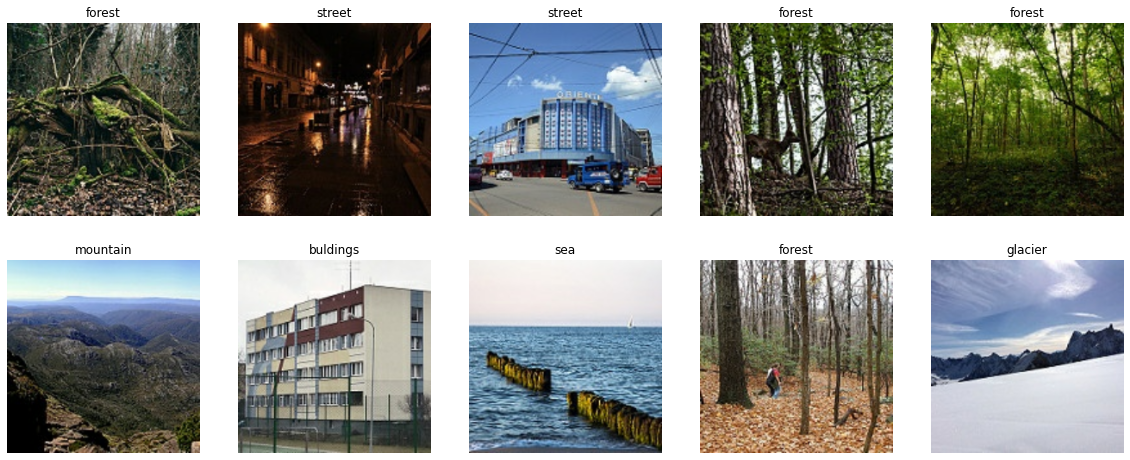

In [18]:
fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1
for image, label in zip(images, labels):
    fig.add_subplot(rows, cols, x)
    plt.imshow(image/255.)
    plt.axis("off")
    plt.title(label)
    x += 1

In [19]:
data_augmentation_block = tf.keras.models.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
], name="data_augmentation")

In [20]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [21]:
dir_name = "model_logs"
experiment_name = "EfficientNetB4 feature extraction"
tensorboarder = create_tensorboard_callback(dir_name, experiment_name)

Saving TensorBoard log files to: model_logs/EfficientNetB4 feature extraction/20230315-113757


In [54]:
checkpoint_path = "checkpoints/model.ckpt"
checkpointer = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 monitor="val_accuracy",
                                                 save_best_only=False,
                                                 save_weights_only=True)

In [55]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                               patience=3,
                                               restore_best_weights=True)

In [56]:
base = tf.keras.applications.EfficientNetB4(include_top=False)
base.trainable = False

In [57]:
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation_block(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(CLASS_NAMES), activation="softmax", name="output_layer")(x)
model = tf.keras.models.Model(inputs, outputs)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])

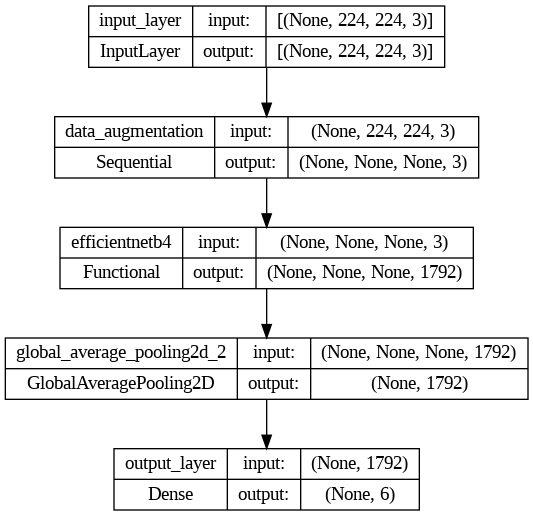

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [59]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb4 (Functional)  (None, None, None, 1792)  17673823 
                                                                 
 global_average_pooling2d_2   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 6)                 10758     
                                                                 
Total params: 17,684,581
Trainable params: 10,758
Non-train

In [60]:
history = model.fit(train_data, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(test_data), 
                    callbacks=[tensorboarder, checkpointer, earlystopper],
                    validation_steps=int(0.15*len(test_data)), 
                    use_multiprocessing=True)

Epoch 1/50


439/439 [==============================] - 198s 414ms/step - loss: 0.4489 - accuracy: 0.8484 - val_loss: 0.2692 - val_accuracy: 0.9062
Epoch 2/50
439/439 [==============================] - 177s 402ms/step - loss: 0.3141 - accuracy: 0.8866 - val_loss: 0.2141 - val_accuracy: 0.9308
Epoch 3/50
439/439 [==============================] - 154s 350ms/step - loss: 0.2868 - accuracy: 0.8961 - val_loss: 0.2413 - val_accuracy: 0.9174
Epoch 4/50
439/439 [==============================] - 152s 345ms/step - loss: 0.2766 - accuracy: 0.8975 - val_loss: 0.2540 - val_accuracy: 0.9174
Epoch 5/50
439/439 [==============================] - 145s 328ms/step - loss: 0.2671 - accuracy: 0.9020 - val_loss: 0.2961 - val_accuracy: 0.8996


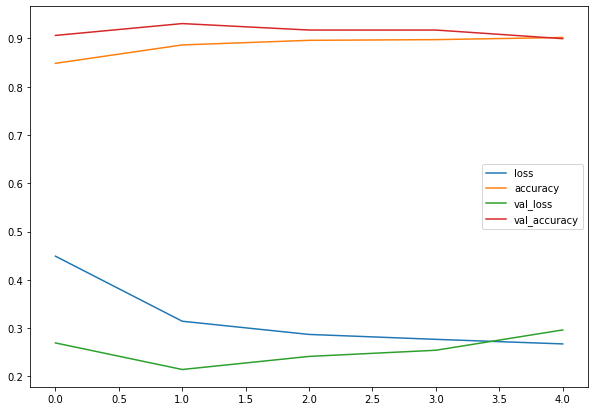

In [61]:
pd.DataFrame(history.history).plot(figsize=(10,7))
plt.show()

In [62]:
model.evaluate(test_data)

94/94 [==============================] - 14s 150ms/step - loss: 0.2518 - accuracy: 0.9163


[0.2517565190792084, 0.9163333177566528]

In [63]:
predictions = model.predict(test_data)

94/94 [==============================] - 16s 142ms/step


In [64]:
predictions.shape

(3000, 6)

In [65]:
predictions = tf.argmax(predictions, axis=1)

In [66]:
y_test = []
for _, label in tqdm(test_data.unbatch()):
    y_test.append(tf.argmax(label))

0it [00:00, ?it/s]

In [67]:
y_test = tf.Variable(y_test)

In [68]:
print(accuracy_score(y_test, predictions))

0.9163333333333333


In [69]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       437
           1       0.99      1.00      0.99       474
           2       0.85      0.85      0.85       553
           3       0.89      0.82      0.86       525
           4       0.92      0.98      0.95       510
           5       0.94      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



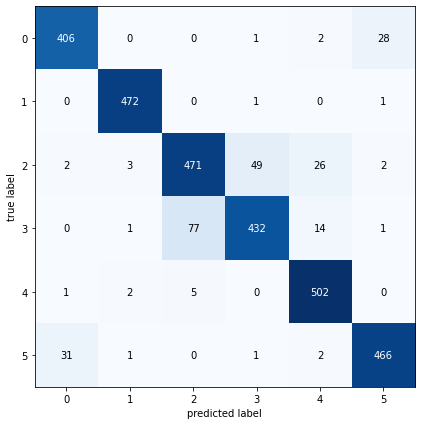

In [70]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, figsize=(10,7))
plt.show()

In [71]:
model.save_weights("efficientnetb4.h5")

In [72]:
model.load_weights("efficientnetb4.h5")
model.evaluate(test_data)

94/94 [==============================] - 14s 149ms/step - loss: 0.2518 - accuracy: 0.9163


[0.2517565190792084, 0.9163333177566528]

In [73]:
base.trainable = True
for layer in base.layers[:-10]:
    layer.trainable = False

In [74]:
model.compile(loss="categorical_crossentropy",
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.00007),
             metrics=["accuracy"])

In [75]:
history_fine_tuning = model.fit(train_data, 
                                epochs=50, 
                                batch_size=32, 
                                validation_data=(test_data), 
                                callbacks=[tensorboarder, checkpointer, earlystopper],
                                validation_steps=int(0.15*len(test_data)), 
                                use_multiprocessing=True,
                                initial_epoch=history.epoch[-1])

Epoch 5/50


439/439 [==============================] - 169s 347ms/step - loss: 0.2717 - accuracy: 0.9010 - val_loss: 0.2814 - val_accuracy: 0.9085
Epoch 6/50
439/439 [==============================] - 141s 321ms/step - loss: 0.2492 - accuracy: 0.9085 - val_loss: 0.2539 - val_accuracy: 0.9219
Epoch 7/50
439/439 [==============================] - 137s 313ms/step - loss: 0.2300 - accuracy: 0.9148 - val_loss: 0.2182 - val_accuracy: 0.9196
Epoch 8/50
439/439 [==============================] - 143s 325ms/step - loss: 0.2099 - accuracy: 0.9230 - val_loss: 0.2273 - val_accuracy: 0.9219
Epoch 9/50
439/439 [==============================] - 142s 323ms/step - loss: 0.2073 - accuracy: 0.9245 - val_loss: 0.2441 - val_accuracy: 0.9152


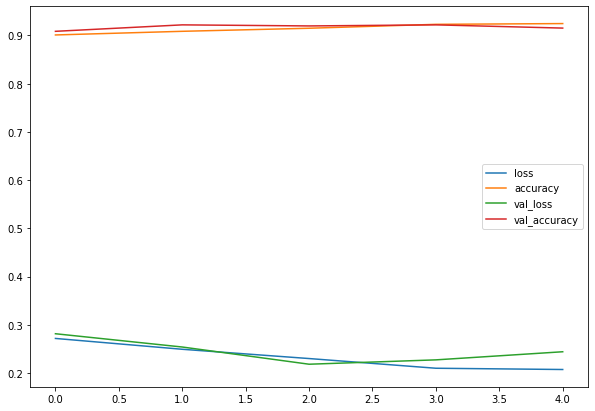

In [76]:
pd.DataFrame(history_fine_tuning.history).plot(figsize=(10,7))
plt.show()

In [77]:
model.evaluate(test_data)

94/94 [==============================] - 14s 149ms/step - loss: 0.2103 - accuracy: 0.9253


[0.21026122570037842, 0.9253333210945129]

In [78]:
predictions = model.predict(test_data)
predictions = tf.argmax(predictions, axis=1)
y_test = []
for _, label in tqdm(test_data.unbatch()):
    y_test.append(tf.argmax(label))
y_test = tf.Variable(y_test)

94/94 [==============================] - 18s 142ms/step


0it [00:00, ?it/s]

In [79]:
print(accuracy_score(y_test, predictions))

0.9253333333333333


In [80]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       437
           1       0.99      1.00      0.99       474
           2       0.89      0.83      0.86       553
           3       0.87      0.88      0.87       525
           4       0.94      0.98      0.96       510
           5       0.93      0.95      0.94       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.92      0.93      0.92      3000



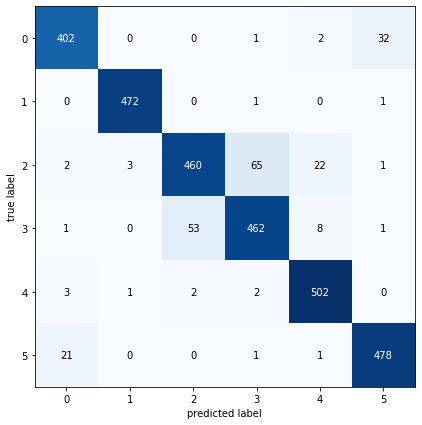

In [82]:
cm = confusion_matrix(y_test, predictions)
plot_confusion_matrix(cm, figsize=(10,7))
plt.show()

In [83]:
model.save_weights("efficientnetb4_fine_tuned.h5")

In [85]:
model.load_weights("efficientnetb4_fine_tuned.h5")
model.evaluate(test_data)

94/94 [==============================] - 15s 153ms/step - loss: 0.2103 - accuracy: 0.9253


[0.21026122570037842, 0.9253333210945129]